In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import ast
import pandas as pd

df = pd.read_csv("/kaggle/input/beasc-avd-extraction/beasc_embeddings.csv")

df2 = pd.read_csv("/kaggle/input/opensmile-beasc/opensmileDF_beasc.csv")

df3 = df.merge(df2, how="left",on=["Path"])
df3.head()
df3['feature_embeddings'] = df3['feature_embeddings'].apply(ast.literal_eval)

Accuracy: 0.66


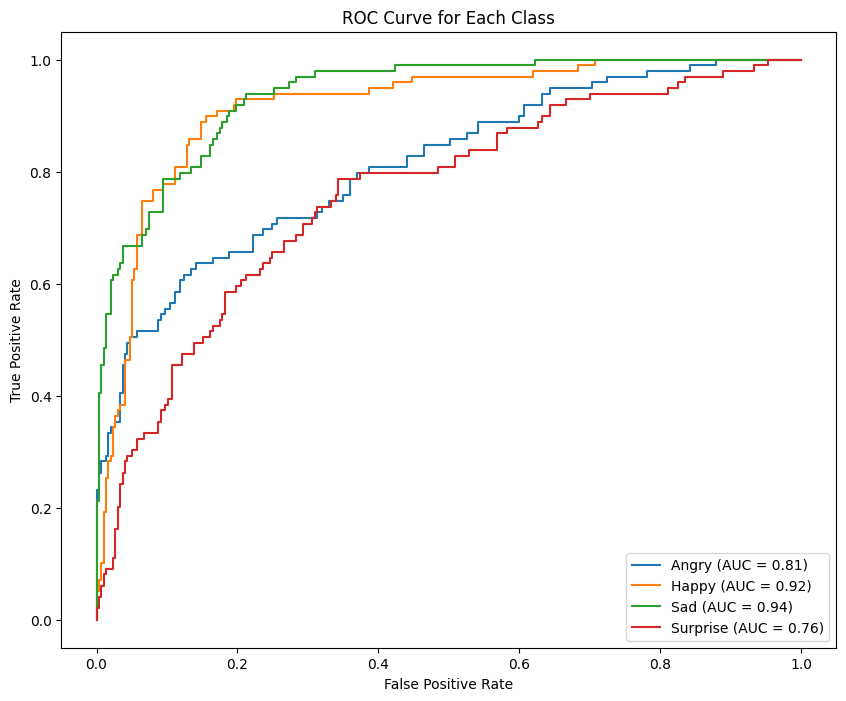

              precision    recall  f1-score   support

       Angry       0.61      0.54      0.57        99
       Happy       0.73      0.81      0.77        99
         Sad       0.73      0.79      0.76        99
    Surprise       0.55      0.52      0.53        99

    accuracy                           0.66       396
   macro avg       0.65      0.66      0.66       396
weighted avg       0.65      0.66      0.66       396



OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True))

In [2]:
def train_svm(df):
    unique_subjects = df['ActorID'].unique()
    train_subjects, temp_subjects = train_test_split(unique_subjects, test_size=0.3, random_state=42)
    
    train_df = df[df['ActorID'].isin(train_subjects)]
    test_df = df[df['ActorID'].isin(temp_subjects)]

    X_train = np.vstack(train_df['feature_embeddings'].values)
    X_test = np.vstack(test_df['feature_embeddings'].values)
    y_train = train_df['Emotion'].values
    y_test = test_df['Emotion'].values

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the SVM
    svm = OneVsRestClassifier(SVC(kernel='linear', probability=True))
    svm.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Get decision function scores to plot ROC curves
    y_score = svm.decision_function(X_test)
    classes = np.unique(y_train)

    # Calculate ROC AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(classes):
        fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()

    # Also print the classification report
    print(classification_report(y_test, y_pred))

    return svm

train_svm(df3)